Lior Attias (lra2135)

Final Project for ML4FG

Data setup

Data Setup 1: One-hot encode the DNA methylation data into the DNA data like so:

A

C

G

T

M


Where M is if the position is usually (more than 50% of the time) methylated

Tool setup:

In [ ]:
!pip3 install torch==1.4.0

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
assert(torch.cuda.is_available()) # if this fails go to Runtime -> Change runtime type -> Set "Hardware Accelerator"
print("Torch version:", torch.__version__)

Torch version: 1.4.0


In [ ]:
%load_ext Cython

In [ ]:
%%cython

import numpy as np
np.get_include() # do we need this on colab? 
cimport cython
cimport numpy as np

cdef dict bases={ 'A':<int>0, 'C':<int>1, 'G':<int>2, 'T':<int>3, 'M':<int>4} 

@cython.boundscheck(False)
def one_hot( str string ):
    cdef np.ndarray[np.float32_t, ndim=2] res = np.zeros( (5,len(string)), dtype=np.float32 )
    cdef int j
    for j in range(len(string)):
        if string[j] in bases: # bases can be 'N' signifying missing: this corresponds to all 0 in the encoding
            res[ bases[ string[j] ], j ]=float(1.0)
    return(res)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn.functional as F

Import methylation data:

In [ ]:
import pandas as pd
DATADIR = "/content/drive/MyDrive/Colab Notebooks/finalproj/" # might need to change this
binding_data = pd.read_csv(DATADIR + "ENCFF690FNR.bed.gz", sep='\t', usecols=range(11), names=("chrom","start","end","name","score","strand", "thickStart", "thickEnd", "itemRgb", "Coverage", "MethlPercent"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
binding_data[:10]

#'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,Coverage,MethlPercent
0,chr1,10468,10469,1,1,+,10468,10469,"0,255,0",1,0
1,chr1,10469,10470,1,4,-,10469,10470,"155,255,0",4,25
2,chr1,10470,10471,1,1,+,10470,10471,"255,0,0",1,100
3,chr1,10471,10472,1,2,-,10471,10472,"255,0,0",2,100
4,chr1,10483,10484,1,1,+,10483,10484,"255,0,0",1,100
5,chr1,10484,10485,1,1,-,10484,10485,"255,0,0",1,100
6,chr1,10488,10489,1,1,+,10488,10489,"255,0,0",1,100
7,chr1,10489,10490,1,1,-,10489,10490,"255,0,0",1,100
8,chr1,10492,10493,1,1,+,10492,10493,"255,0,0",1,100
9,chr1,10493,10494,1,1,-,10493,10494,"0,255,0",1,0


In [ ]:
binding_data[:10]

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,Coverage,MethlPercent
0,chr1,10468,10469,1,1,+,10468,10469,"0,255,0",1,0
1,chr1,10469,10470,1,4,-,10469,10470,"155,255,0",4,25
2,chr1,10470,10471,1,1,+,10470,10471,"255,0,0",1,100
3,chr1,10471,10472,1,2,-,10471,10472,"255,0,0",2,100
4,chr1,10483,10484,1,1,+,10483,10484,"255,0,0",1,100
5,chr1,10484,10485,1,1,-,10484,10485,"255,0,0",1,100
6,chr1,10488,10489,1,1,+,10488,10489,"255,0,0",1,100
7,chr1,10489,10490,1,1,-,10489,10490,"255,0,0",1,100
8,chr1,10492,10493,1,1,+,10492,10493,"255,0,0",1,100
9,chr1,10493,10494,1,1,-,10493,10494,"0,255,0",1,0


If desired, print methylation data to a CSV to better understand the data:

In [ ]:
binding_data[:10].to_csv("/content/drive/MyDrive/Colab Notebooks/finalproj/lior_ml_first.csv")

Intall the genome database, which translate loci to nuclei based on 2013 human genome sequencing:

In [ ]:
!apt install unzip
!unzip "/content/drive/MyDrive/Colab Notebooks/finalproj/hg38-002.pkl.zip"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Archive:  /content/drive/MyDrive/Colab Notebooks/finalproj/hg38-002.pkl.zip
  inflating: hg38-002.pkl            
  inflating: __MACOSX/._hg38-002.pkl  


In [ ]:
import pickle
#genome = pickle.load(open(DATADIR+"hg38-002.pkl","rb")) # this is here in case there's hg38 data you want to analyse
genome = pickle.load(open("hg38-002.pkl","rb"))

Set up test, validation, and training data. Split by chromosomes:

In [ ]:
test_chromosomes = ["chr1"]
test_data = binding_data[ binding_data['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = binding_data[ binding_data['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = binding_data[ binding_data['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / binding_data.shape[0], validation_data.shape[0] / binding_data.shape[0]

(0.08433659069333037, 0.14514896300681587)

If desired, write the training data to a csv to better understand and view the data

In [ ]:
train_data.to_csv("/content/drive/MyDrive/Colab Notebooks/finalproj/lior_ml_first_1.csv")

Visualize the genome database:

In [ ]:
genome["chr13"][100000000:100000010]

'CATTCAAGGA'

In [ ]:
genome["chr13"].count("N") / len(genome["chr13"])

Before we One-hot encoded the DNA and methylation data, we need to RNA expression levels (measured by TPM) to the loci of each gene.

We will do this by relating the loci in the DB we loaded above to loci in the Genome DB. Then, we relate the corresponding gene ID to the gene ID in the file that shows us the RNA Expression levels (see below).

FIrst, load the database containing Gene ID and start and end loci: 

In [ ]:
#first, relate the loci of each nucleotide to a gene

#let's load our genes

# DATADIR = "/content/drive/MyDrive/Colab Notebooks/finalproj/" # might need to change this
genes_loci = pd.read_csv(DATADIR + "genes.tsv", sep='\t', usecols=range(6), names=("chrom","start","end","strand","gene_name","gene_id"))
genes_loci = genes_loci[ ~genes_loci['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
genes_loci = genes_loci.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
genes_loci[:10]

,chrom,start,end,strand,gene_name,gene_id
0,chr,start,end,strand,gene_name,gene_id
2365,chr1,100000637,100000739,-,RNU6-1318P,ENSG00000202259
2366,chr1,100038095,100083377,+,MFSD14A,ENSG00000156875
2367,chr1,100057990,100084471,-,AC093019.2,ENSG00000241073
2368,chr1,100083563,100132955,-,SASS6,ENSG00000156876
2369,chr1,100099239,100099490,+,AC093019.1,ENSG00000226952
67,chr1,1001138,1014540,+,ISG15,ENSG00000187608
2370,chr1,100133150,100150498,+,TRMT13,ENSG00000122435
2371,chr1,100148449,100178273,-,LRRC39,ENSG00000122477
2372,chr1,100186919,100249834,-,DBT,ENSG00000137992


Split the genes in the entire human genome by chromosome, and use the following split for train, test, and validation data. We use the same split as for the previous databases:

In [ ]:
#split into training dataset
test_chromosomes_f = ["chr1"]
test_data_f = genes_loci[ genes_loci['chrom'].isin( test_chromosomes_f ) ]

validation_chromosomes_f = ["chr2","chr3"]
validation_data_f = genes_loci[ genes_loci['chrom'].isin(validation_chromosomes_f) ]

train_chromosomes_f = ["chr%i" % i for i in range(4, 22+1)]
train_data_f = genes_loci[ genes_loci['chrom'].isin( train_chromosomes_f ) ]

test_data_f.shape[0] / genes_loci.shape[0], validation_data_f.shape[0] / genes_loci.shape[0]

(0.09536667799216753, 0.1268038840507144)

Load the gene expression data:

In [ ]:
#now, we need each gene range to correlate to a nucleotide

In [ ]:
#will do this via linear regression
#[ 0 1 0 1 0 0  0 0 1] --> expression level
#where 0 is unmethylated and 1 is methylated position

In [ ]:
#load gene expression data

# DATADIR = "/content/drive/MyDrive/Colab Notebooks/finalproj/" # might need to change this
expression_db = pd.read_csv(DATADIR + "ENCFF292KIL.tsv", sep='\t', usecols=range(6), names=("gene_id","tran_id","EL","EC","TPM","FPKM"))
# expression_db = expression_db[ ~expression_db['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
# expression_db = expression_db.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives
expression_db[:10]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,gene_id,tran_id,EL,EC,TPM,FPKM
0,gene_id,transcript_id(s),length,effective_length,expected_count,TPM
1,10904,10904,93.00,0.00,0.00,0.00
2,12954,12954,94.00,0.00,0.00,0.00
3,12956,12956,72.00,0.00,0.00,0.00
4,12958,12958,82.00,0.00,0.00,0.00
5,12960,12960,73.00,0.00,0.00,0.00
6,12962,12962,72.00,0.00,0.00,0.00
7,12964,12964,74.00,0.00,0.00,0.00
8,12965,12965,82.00,0.00,0.00,0.00
9,12967,12967,73.00,0.00,0.00,0.00


In [ ]:
expression_db[:10]


,gene_id,tran_id,EL,EC,TPM,FPKM
0,gene_id,transcript_id(s),length,effective_length,expected_count,TPM
1,10904,10904,93.00,0.00,0.00,0.00
2,12954,12954,94.00,0.00,0.00,0.00
3,12956,12956,72.00,0.00,0.00,0.00
4,12958,12958,82.00,0.00,0.00,0.00
5,12960,12960,73.00,0.00,0.00,0.00
6,12962,12962,72.00,0.00,0.00,0.00
7,12964,12964,74.00,0.00,0.00,0.00
8,12965,12965,82.00,0.00,0.00,0.00
9,12967,12967,73.00,0.00,0.00,0.00


Create the Complete Encoded Methylation data.

For each gene on each chromosome (for which we have TPM (Transcript Per Million, a measure of gene expession ) data), get the sequence of the gene and replace the methylated loci in the sequence with 'M'.

Example: AGTCMGACTMMA...

One hot encode the methylated sequence, and set the label (value to be predicted) as the TPM value.

In [ ]:
#Create Data set 1: complete methylation database 
import math

class LiorDataset(torch.utils.data.IterableDataset):

    def __init__(self, genes_loci_info, genome, context_length, meth_data_info, expr_info):
        super(LiorDataset, self).__init__()
        self.context_length = context_length
        self.meth_data = meth_data_info
        #genes_loci is the list of genes
        self.genes_loci = genes_loci_info
        #genome is the translation of loci to nucleotide
        self.genome = genome
        self.expr_data = expr_info

    def __iter__(self):
        prev_end = 0
        prev_chrom = ""
        
        #reduce DB size
        cur_chr = ""
        nxt_chr = ""
        chrom_counter_i = -1

        
        for i,row in enumerate(self.genes_loci.itertuples()):
            if(row.strand == '-'):
              continue

            chrom_counter_i = chrom_counter_i + 1
            # print(chrom_counter_i)
            # print(row.chrom)
            if (chrom_counter_i > 10):
              #do nothing until we get to the next chromosome
              if (prev_chrom == row.chrom):
                donothing = 1
                #then do nothing
              else:
                #got to next chromo
                chrom_counter_i = -1
            else:
              
              seq = self.genome[row.chrom][int(row.start) - 1000 : int(row.start) + 300]
              #get the methylation positions
              all_nuc_on_chromo = self.meth_data.loc[self.meth_data['chrom'] == row.chrom]
              for i_t, row_t in enumerate(all_nuc_on_chromo.itertuples()):
                if((int(row_t.start) >= int(row.start) - 1000 ) and (int(row_t.start) <= int(row.start) + 300)):
                  if (int(row_t.MethlPercent) > 50):
                    loc_rel = 0
                    if (int(row_t.start) <= int(row.start)):
                      loc_rel = int(row_t.start) - int(row.start) + 1000 - 1
                    else:
                      loc_rel = int(row_t.start) - int(row.start) + 300
                    seq = seq[:loc_rel] + 'M' + seq[loc_rel + 1 :]

              #now, get the expression level in TPM for the gene from the ff29 DB
              possible_values_of_gene = [row.gene_id + ".1", 
                                         row.gene_id + ".2",
                                         row.gene_id + ".3",
                                         row.gene_id + ".4",
                                         row.gene_id + ".5",
                                         row.gene_id + ".6",
                                         row.gene_id + ".7",
                                         row.gene_id + ".8",
                                         row.gene_id + ".9",
                                         row.gene_id + ".10",
                                         row.gene_id + ".11",
                                         row.gene_id + ".12",
                                         row.gene_id + ".13",
                                         row.gene_id + ".14",
                                         row.gene_id + ".15",
                                         row.gene_id + ".16",
                                         row.gene_id + ".17",
                                         row.gene_id + ".19",
                                         row.gene_id + ".20",
                                         row.gene_id + ".30",
                                         row.gene_id + ".40",
                                         row.gene_id + ".50",
                                         row.gene_id + ".60",
                                         row.gene_id + ".70",
                                         row.gene_id + ".80",
                                         row.gene_id + ".90",
                                         row.gene_id + ".1"+ "_PAR_Y", 
                                         row.gene_id + ".2"+ "_PAR_Y",
                                         row.gene_id + ".3"+ "_PAR_Y",
                                         row.gene_id + ".4"+ "_PAR_Y",
                                         row.gene_id + ".5"+ "_PAR_Y",
                                         row.gene_id + ".6"+ "_PAR_Y",
                                         row.gene_id + ".7"+ "_PAR_Y",
                                         row.gene_id + ".8"+ "_PAR_Y",
                                         row.gene_id + ".9"+ "_PAR_Y"]

              expr_tpm_row = ""
              for iter in possible_values_of_gene:
                expr_tpm_row = self.expr_data.loc[self.expr_data['gene_id'] == iter]
                if(len(expr_tpm_row) > 0):
                  break

              expr_tpm = expr_tpm_row.TPM
              if(len(expr_tpm_row) > 0):
                if(len(seq) == 1300):
                  yield(one_hot(seq), np.float32(expr_tpm.values[0]))
 
            prev_chrom = row.chrom
            prev_end = row.end

# train_data_f is genes loci (iterates through each gene in the gene, chromosome databse)
# train_data is = methylation data

train_dataset_f= LiorDataset(train_data_f, genome, 10, train_data, expression_db)
train_dataloader_f = torch.utils.data.DataLoader(train_dataset_f, batch_size=1000, num_workers = 0)

#print("oy")
train_data_f

Create the simplest CNN as a baseline and to sanity check:

In [ ]:
torch.manual_seed(2) # I played with different initialization here! 
my_first_conv_layer = nn.Conv1d(5, 1, 14, padding = 0) # 5 input channels, 1 output channels, filter width 14, no padding
my_first_conv_layer

In [ ]:
def my_simplest_CNN(x): 
    net = my_first_conv_layer(x)
    net = net[:,0,:] # only one output channel! 
    # take maximum over channel ("global max pooling")
    net = torch.max(net, dim=1).values # max returns namedtuple (values, indices)
    net = torch.sigmoid(net) # aka logistic to get output in [0,1]
    return(net) 

Train Dataset1 (Complete Methylated Encoded dataset) through the simplest CNN:

In [ ]:
import timeit
start_time = timeit.default_timer()

torch.set_grad_enabled(True) # we'll need gradients

for epoch in range(10): # run for this many epochs
    losses = []
    accuracies = []
    for (x,y) in train_dataloader_f: # iterate over minibatches

        output = my_simplest_CNN(x) # forward pass
        # in practice (and below) we'll use more numerically stable built-in
        # functions for the loss
        loss = - torch.mean( y * torch.log(output) + (1.-y) * torch.log(1.-output) )
        loss.backward() # back propagation

        # iterate over parameter tensors: just the layer1 weights and bias here
        for parameters in my_first_conv_layer.parameters(): 
            parameters.data -= 1.0 * parameters.grad # in practive reduce or adapt learning rate
            parameters.grad.data.zero_() # torch accumulates gradients so need to reset
        
        losses.append(loss.detach().numpy()) # convert back to numpy
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().numpy())  

    elapsed = float(timeit.default_timer() - start_time)
    print("Epoch %i %.2fs/epoch Loss: %.4f Acc: %.4f" % (epoch+1, elapsed/(epoch+1), np.mean(losses), np.mean(accuracies)))


In [ ]:
print(losses)
for item in losses:
  print(item)
print(accuracies)
for item in accuracies:
  print(accuracies)

Average accuracy on validation data (dataset 1 on simplest CNN):

In [ ]:
validation_dataset = LiorDataset(validation_data_f, genome, 100, validation_data, expression_db)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)
accuracies = [ torch.mean( ( (my_simplest_CNN(x)  > .5) == (y > .5) ).float() ).detach().cpu().numpy() for (x,y) in validation_dataloader ]
np.mean(accuracies)

0.6363636

In [ ]:
#save off a copy of the final datasets
train_dataset_DB1 = train_dataset_f
train_dataloader_DB1 = train_dataloader_f

train_dataset_DB1 = train_data_f

In [ ]:
validation_dataset_db1 = validation_dataset
validation_dataloader_db1 = validation_dataloader
accuracies_db1 = accuracies

Set up dataset 2: multiple partial methylation encoding.

Dataset2 iterates through each methylated loci and relates it to a gene. Each one-hot encoded sequence therefore only has 1 methylated loci, and for genes with multiple methylated loci, there will be multiple one hot encoded matrixes.

This dataset is used only for experimentation

In [ ]:
# Dataset 2 setup
import math

class LiorDataset2(torch.utils.data.IterableDataset):

    def __init__(self, genes_loci_info, genome, context_length, meth_data_info, expr_info):
        super(LiorDataset2, self).__init__()
        self.context_length = context_length
        self.meth_data = meth_data_info
        #genes_loci is the list of genes
        self.gene_loci = genes_loci_info
        #genome is the translation of loci to nucleotide
        self.genome = genome
        self.expr_data = expr_info

    def __iter__(self):
        prev_end = 0
        prev_chrom = ""
        
        #reduce DB size
        cur_chr = ""
        nxt_chr = ""
        chrom_counter_i = -1

        
        for i,row in enumerate(self.meth_data.itertuples()):
            if(row.strand == '-'):
              continue

            chrom_counter_i = chrom_counter_i + 1
            #if(False):
            if (chrom_counter_i > 100):
              #do nothing until we get to the next chromosome
              if (prev_chrom == row.chrom):
                donothing = 1
                #then do nothing
              else:
                #got to next chromo
                chrom_counter_i = -1
            else:
              
              #to which sequence does this little nucleotide belong?
              gene_chromo = self.gene_loci.loc[self.gene_loci['chrom'] == row.chrom]
              gene_strand = gene_chromo.loc[gene_chromo['strand'] == row.strand]

              gene_found = row
 
              for i_s, row_s in enumerate(gene_strand.itertuples()):
                if ((int(row_s.start) - 300) <= row.start) and ((int(row_s.start) + 300) >= row.start):
                  gene_found = row_s
              

              if row == gene_found:
                continue

              seq = self.genome[row.chrom][int(gene_found.start) - 1000 : int(gene_found.start) + 300]
             
              is_methylated = row.MethlPercent
              loc_relative = 0
              if is_methylated > 50:
                loc_rel = 0
                if (int(gene_found.start) <= int(row.start)):
                  loc_rel = int(gene_found.start) - int(row.start) + 1000 - 1
                else:
                  loc_rel = int(gene_found.start) - int(row.start) + 300
                seq = seq[:loc_rel] + 'M' + seq[loc_rel + 1 :]

              #now, get the expression level in TPM for the gene from the ff29 DB
              possible_values_of_gene = [gene_found.gene_id + ".1", 
                                         gene_found.gene_id + ".2",
                                         gene_found.gene_id + ".3",
                                         gene_found.gene_id + ".4",
                                         gene_found.gene_id + ".5",
                                         gene_found.gene_id + ".6",
                                         gene_found.gene_id + ".7",
                                         gene_found.gene_id + ".8",
                                         gene_found.gene_id + ".9",
                                         gene_found.gene_id + ".10",
                                         gene_found.gene_id + ".11",
                                         gene_found.gene_id + ".12",
                                         gene_found.gene_id + ".13",
                                         gene_found.gene_id + ".14",
                                         gene_found.gene_id + ".15",
                                         gene_found.gene_id + ".16",
                                         gene_found.gene_id + ".17",
                                         gene_found.gene_id + ".19",
                                         gene_found.gene_id + ".20",
                                         gene_found.gene_id + ".30",
                                         gene_found.gene_id + ".40",
                                         gene_found.gene_id + ".50",
                                         gene_found.gene_id + ".60",
                                         gene_found.gene_id + ".70",
                                         gene_found.gene_id + ".80",
                                         gene_found.gene_id + ".90",
                                         gene_found.gene_id + ".1"+ "_PAR_Y", 
                                         gene_found.gene_id + ".2"+ "_PAR_Y",
                                         gene_found.gene_id + ".3"+ "_PAR_Y",
                                         gene_found.gene_id + ".4"+ "_PAR_Y",
                                         gene_found.gene_id + ".5"+ "_PAR_Y",
                                         gene_found.gene_id + ".6"+ "_PAR_Y",
                                         gene_found.gene_id + ".7"+ "_PAR_Y",
                                         gene_found.gene_id + ".8"+ "_PAR_Y",
                                         gene_found.gene_id + ".9"+ "_PAR_Y"]

              expr_tpm_row = ""
              for iter in possible_values_of_gene:
                expr_tpm_row = self.expr_data.loc[self.expr_data['gene_id'] == iter]
                if(len(expr_tpm_row) > 0):
                  break

              expr_tpm = expr_tpm_row.TPM

              if(len(expr_tpm_row) > 0):
                yield(one_hot(seq), np.float32(expr_tpm.values[0]))
              
            prev_chrom = row.chrom
            prev_end = row.end

#train_data_f is genes loci
#train_data is atack data = methlatino data

train_dataset_f_db2= LiorDataset2(train_data_f, genome, 10, train_data, expression_db)
train_dataloader_f_db2 = torch.utils.data.DataLoader(train_dataset_f_db2, batch_size=1000, num_workers = 0)


train_data_f

,chrom,start,end,strand,gene_name,gene_id
30006,chr10,100042193,100081877,-,CPN1,ENSG00000120054
30007,chr10,100105754,100140151,-,CYP2C23P,ENSG00000283232
30008,chr10,100114417,100115223,-,TPM4P1,ENSG00000232230
30009,chr10,100143065,100143995,-,SPCS2P2,ENSG00000270623
30010,chr10,100150094,100186033,-,ERLIN1,ENSG00000107566
...,...,...,...,...,...,...
27489,chr9,99886322,99906601,-,STX17-AS1,ENSG00000255145
27490,chr9,99906654,99974534,+,STX17,ENSG00000136874
27491,chr9,99915077,99929896,-,AL358937.1,ENSG00000254571
27492,chr9,99979185,100099000,-,ERP44,ENSG00000023318


Train on dataset2 on simplest CNN, but use an L2 loss this time

In [ ]:
import timeit
start_time = timeit.default_timer()

torch.set_grad_enabled(True) # we'll need gradients

for epoch in range(10): # run for this many epochs
    losses = []
    accuracies = []
    for (x,y) in train_dataloader_f_db2: # iterate over minibatches

        output = my_simplest_CNN(x) # forward pass
        loss = nn.MSELoss()
        theloss = loss(y, output)
        theloss.backward() # back propagation

        # iterate over parameter tensors: just the layer1 weights and bias here
        for parameters in my_first_conv_layer.parameters(): 
            parameters.data -= 1.0 * parameters.grad # in practive reduce or adapt learning rate
            parameters.grad.data.zero_() # torch accumulates gradients so need to reset
        
        losses.append(theloss.detach().numpy()) # convert back to numpy
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().numpy())  

    elapsed = float(timeit.default_timer() - start_time)
    print("Epoch %i %.2fs/epoch Loss: %.4f Acc: %.4f" % (epoch+1, elapsed/(epoch+1), np.mean(losses), np.mean(accuracies)))


Epoch 1 78.82s/epoch Loss: nan Acc: 0.9481
Epoch 2 79.71s/epoch Loss: nan Acc: 0.9481
Epoch 3 81.93s/epoch Loss: nan Acc: 0.9481
Epoch 4 80.79s/epoch Loss: nan Acc: 0.9481
Epoch 5 79.93s/epoch Loss: nan Acc: 0.9481
Epoch 6 80.74s/epoch Loss: nan Acc: 0.9481
Epoch 7 81.35s/epoch Loss: nan Acc: 0.9481
Epoch 8 81.10s/epoch Loss: nan Acc: 0.9481
Epoch 9 80.62s/epoch Loss: nan Acc: 0.9481
Epoch 10 80.16s/epoch Loss: nan Acc: 0.9481


Average accuracy on validation data (DB2, simpliest CNN):

In [ ]:

validation_dataset_db2_temp = LiorDataset(validation_data_f, genome, 100, validation_data, expression_db)
validation_dataloader_db2_temp = torch.utils.data.DataLoader(validation_dataset_db2_temp, batch_size=1000)
accuracies = [ torch.mean( ( (my_simplest_CNN(x)  > .5) == (y > .5) ).float() ).detach().cpu().numpy() for (x,y) in validation_dataloader_db2_temp ]
np.mean(accuracies)


0.6363636

Create a more complex fully convolutional neural network (more complex CNN):

use L2 regularization for loss because we expect few outliers

In [ ]:
def run_one_epoch(train_flag, dataloader, cnn_1d, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = cnn_1d(x) # forward pass
        output = output.squeeze() # remove spurious channel dimension
        #loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable
        theloss = nn.MSELoss()
        loss = theloss(output, y)
        
        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())  
    
    return( np.mean(losses), np.mean(accuracies) )


In [ ]:

def train_model(cnn_1d, train_data, validation_data, epochs=100, patience=10, verbose = True):
    """
    Train a 1D CNN model and record accuracy metrics.
    """
    # Move the model to the GPU here to make it runs there, and set "device" as above
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_1d.to(device)

    # 1. Make new Dataset 1 and DataLoader objects for both training and validation data.
    train_dataset = LiorDataset(train_data_f, genome, cnn_1d.seq_len, train_data, expression_db)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)
    validation_dataset = LiorDataset(validation_data_f, genome, cnn_1d.seq_len, validation_data, expression_db)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)
    
    # 2. Instantiates an optimizer for the model. 
    optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True)

    # 3. Run the training loop with early stopping. 
    train_accs = []
    val_accs = []
    #patience = 10 # for early stopping
    patience_counter = patience
    best_val_loss = np.inf
    check_point_filename = 'cnn_1d_checkpoint_new.pt' # to save the best model fit to date
    
    for epoch in range(epochs):
      start_time = timeit.default_timer()
      train_loss, train_acc = run_one_epoch(True, train_dataloader, cnn_1d, optimizer, device)
      val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
      train_accs.append(train_acc)
      val_accs.append(val_acc)
      if val_loss < best_val_loss: 
          torch.save(cnn_1d.state_dict(), check_point_filename)
          best_val_loss = val_loss
          patience_counter = patience
      else: 
          patience_counter -= 1
          if patience_counter <= 0: 
              cnn_1d.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
              break
      elapsed = float(timeit.default_timer() - start_time)
      print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
          (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))

    # 4. Return the fitted model (not strictly necessary since this happens "in place"), train and validation accuracies.
    return cnn_1d, train_accs, val_accs;

In [ ]:
class CNN_1d(nn.Module):

    def __init__(self, 
                 n_output_channels = 1, 
                 filter_widths = [15, 5], 
                 num_chunks = 5, 
                 max_pool_factor = 4, 
                 nchannels = [5, 32, 32],
                 n_hidden = 32, 
                 dropout = 0.2):
        
        super(CNN_1d, self).__init__()
        self.rf = 0 # running estimate of the receptive field
        self.chunk_size = 1 # running estimate of num basepairs corresponding to one position after convolutions

        conv_layers = []
        for i in range(len(nchannels)-1):
            conv_layers += [ nn.Conv1d(nchannels[i], nchannels[i+1], filter_widths[i], padding = 0),
                        nn.BatchNorm1d(nchannels[i+1]), # tends to help give faster convergence: https://arxiv.org/abs/1502.03167
                        nn.Dropout2d(dropout), # popular form of regularization: https://jmlr.org/papers/v15/srivastava14a.html
                        nn.MaxPool1d(max_pool_factor), 
                        nn.ELU(inplace=True)  ] # popular alternative to ReLU: https://arxiv.org/abs/1511.07289
            assert(filter_widths[i] % 2 == 1) # assume this
            self.rf += (filter_widths[i] - 1) * self.chunk_size
            self.chunk_size *= max_pool_factor

        # If you have a model with lots of layers, you can create a list first and 
        # then use the * operator to expand the list into positional arguments, like this:
        self.conv_net = nn.Sequential(*conv_layers)

        self.seq_len = num_chunks * self.chunk_size + self.rf # amount of sequence context required

        print("Receptive field:", self.rf, "Chunk size:", self.chunk_size, "Number chunks:", num_chunks)

        self.dense_net = nn.Sequential( nn.Linear(2528, n_hidden, None),
                                        nn.Dropout(dropout),
                                        nn.ELU(inplace=True),
                                        nn.Linear(n_hidden, n_output_channels) )

    def forward(self, x):
        net = self.conv_net(x.to(device))
        net = net.view(net.size(0), -1)
        
        net = self.dense_net(net)
        return(net)

cnn_1d = CNN_1d()

print("Input length:", cnn_1d.seq_len)

cnn_1d

Train dataset 1 on the more complex CNN:

In [ ]:
optimizer = torch.optim.Adam(cnn_1d.parameters(), amsgrad=True)

In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d_final, train_accs_final, val_accs_final = train_model(my_cnn1d, train_data, validation_data)

In [ ]:
train_loss, train_acc = run_one_epoch(False, train_dataloader, cnn_1d, optimizer, device)
val_loss, val_acc = run_one_epoch(False, validation_dataloader, cnn_1d, optimizer, device)
print(train_acc, val_acc)

test_dataset = LiorDataset(test_data_f, genome, cnn_1d.seq_len, test_data, expression_db )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_loss, test_acc = run_one_epoch(False, test_dataloader, cnn_1d, optimizer, device)
test_acc

In [ ]:
test_dataset = LiorDataset(test_data_f, genome, cnn_1d.seq_len, test_data, expression_db )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_loss, test_acc = run_one_epoch(False, test_dataloader, cnn_1d, optimizer, device)
test_acc

Here, I ran a few experiemnts to test. Here, you will see different values. This is because I modified the CNN, ran a test, and then re-modified the CNN. The values below are just for posterity, so you can see where the values in the paper came from:

In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d_final, train_accs_final, val_accs_final = train_model(my_cnn1d, train_data, validation_data)

Receptive field: 30 Chunk size: 16 Number chunks: 5
110
Epoch 1 took 241.61s. Train loss: 628057.2500 acc: 0.5833. Val loss: 897158.2500 acc: 0.2500. Patience left: 10


In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d_final1, train_accs_final2, val_accs_final3 = train_model(my_cnn1d, train_data, validation_data)

Receptive field: 30 Chunk size: 16 Number chunks: 5
110
Epoch 1 took 241.17s. Train loss: -56.3021 acc: 0.5556. Val loss: -345.6036 acc: 0.2500. Patience left: 10


In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d_final1, train_accs_final2, val_accs_final3 = train_model(my_cnn1d, train_data, validation_data)

Receptive field: 30 Chunk size: 16 Number chunks: 5
110


In [ ]:
my_cnn1d = CNN_1d()
print(my_cnn1d.seq_len)
my_cnn1d
my_cnn1d_final1, train_accs_final2, val_accs_final3 = train_model(my_cnn1d, train_data, validation_data)

In [ ]:
test_dataset = LiorDataset(test_data_f, genome, cnn_1d.seq_len, test_data, expression_db )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
device = "cuda"
test_loss, test_acc = run_one_epoch(False, test_dataloader, cnn_1d.to(device), optimizer, device)
test_acc

0.5

Model interpretation via in-silico mutagenesis and saliency maps:

In [ ]:
!pip install logomaker
import logomaker

pwm = my_first_conv_layer.weight.detach().cpu().numpy().squeeze()
pwm -= pwm.mean(0, keepdims=True) # remove spurious degrees of freedom
pwm_df = pd.DataFrame(data = pwm.transpose(), columns=("A","C","G","T"))
crp_logo = logomaker.Logo(pwm_df) # CCACCAGG(G/T)GGCG

In [ ]:
torch.set_grad_enabled(False)
for (x_cpu,y_cpu) in validation_dataloader: 
    x = x_cpu.to(device)
    y = y_cpu.to(device)
    output = cnn_1d(x).squeeze()
    output = torch.sigmoid(output)
    delta_output = torch.zeros_like(x, device=device)
    # loop over all positions changing to each position nucleotide
    # note everything is implicitly parallelized over the batch here
    for seq_idx in range(cnn_1d.seq_len): # iterate over sequence
        for nt_idx in range(4): # iterate over nucleotides
            x_prime = x.clone() # make a copy of x
            x_prime[:,:,seq_idx] = 0. # change the nucleotide to nt_idx
            x_prime[:,nt_idx,seq_idx] = 1.
            output_prime = cnn_1d(x_prime).squeeze()
            output_prime = torch.sigmoid(output_prime)
            delta_output[:,nt_idx,seq_idx] = output_prime - output
    break # just do this for first batch

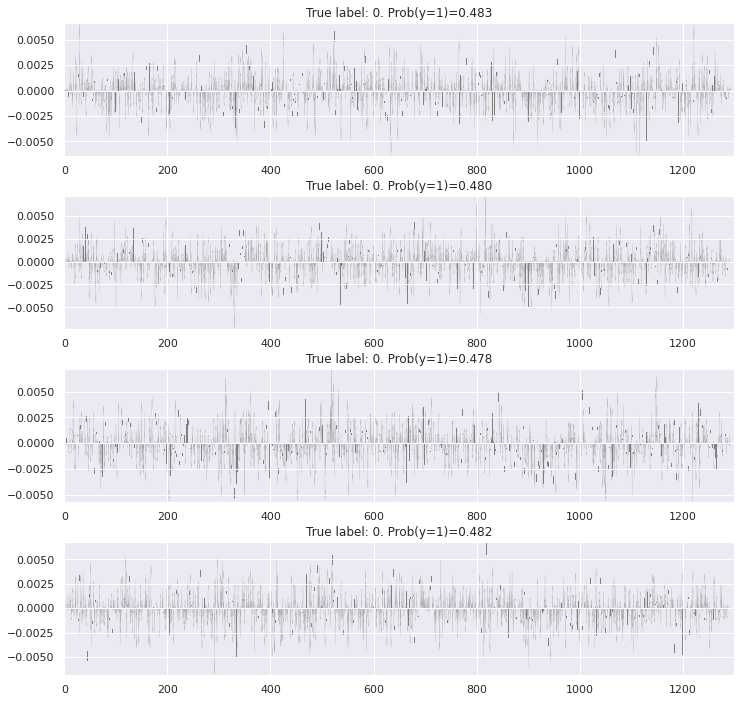

In [ ]:
torch.set_grad_enabled(True)
x.requires_grad_() # tell torch we will want gradients wrt x (which we don't normally need)
output = cnn_1d(x).squeeze()
output = torch.sigmoid(output)
dummy = torch.ones_like(output) # in a multiclass model this would be a one-hot encoding of y
output.backward(dummy) # to get derivative wrt to x
gradient_np = x.grad.detach().cpu().numpy()
output_np = output.detach().cpu().numpy()
saliency = gradient_np * x_cpu.numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i) #,sharey=ax)
    pwm_df = pd.DataFrame(data = saliency[i,:,:].transpose(), columns=("A","C","G","T", "M"))
    logomaker.Logo(pwm_df, ax=ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

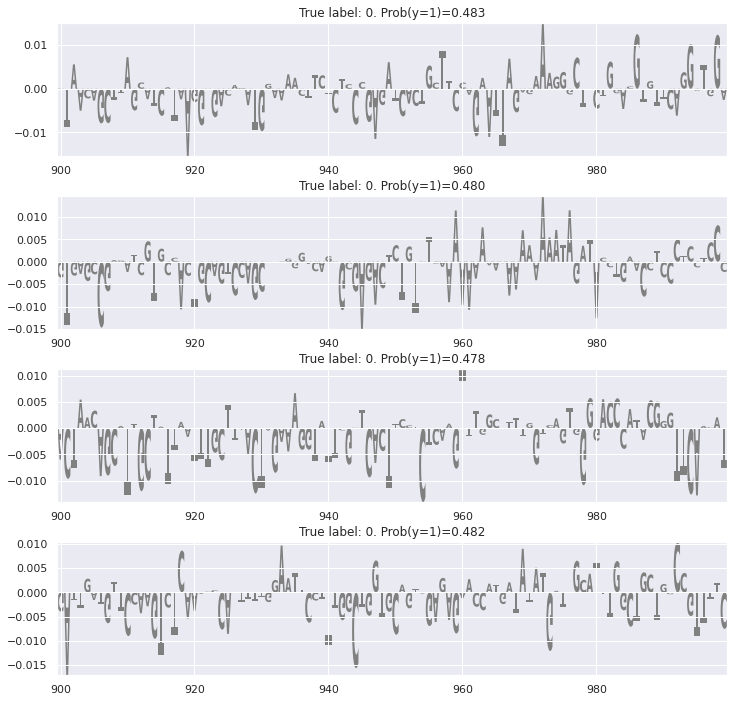

In [ ]:
torch.set_grad_enabled(True)
x.requires_grad_() # tell torch we will want gradients wrt x (which we don't normally need)
output = cnn_1d(x).squeeze()
output = torch.sigmoid(output)
dummy = torch.ones_like(output) # in a multiclass model this would be a one-hot encoding of y
output.backward(dummy) # to get derivative wrt to x
gradient_np = x.grad.detach().cpu().numpy()
output_np = output.detach().cpu().numpy()
saliency = gradient_np * x_cpu.numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i) #,sharey=ax)
    pwm_df = pd.DataFrame(data = saliency[i,:,:].transpose(), columns=("A","C","G","T", "M"))
    logomaker.Logo(pwm_df[900:1000], ax=ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

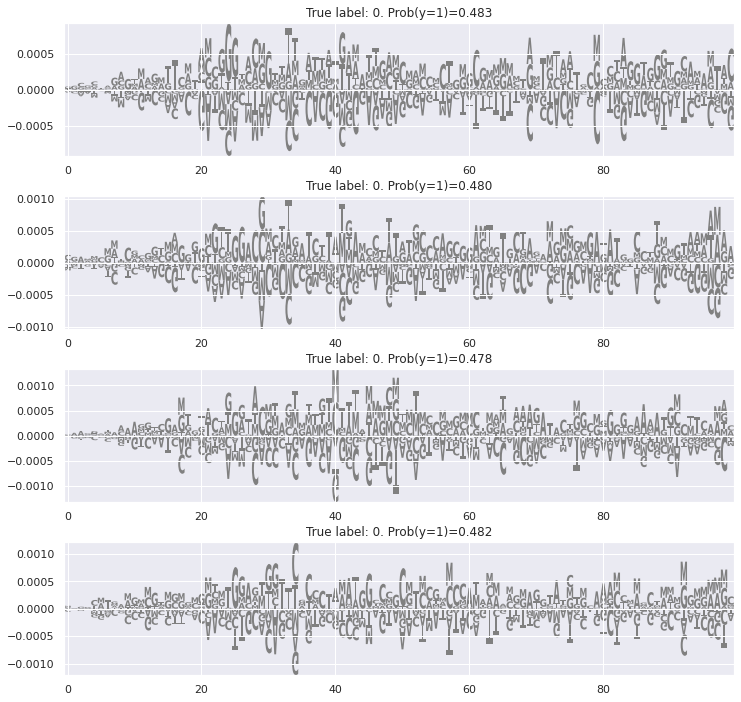

In [ ]:
delta_output_np = delta_output.detach().cpu().numpy()
delta_output_np -= delta_output_np.mean(1, keepdims=True)
output_np = output.detach().cpu().numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i)
    pwm_df = pd.DataFrame(data = delta_output_np[i,:,:].transpose(), columns=("A","C","G","T", "M"))
    crp_logo = logomaker.Logo(pwm_df[:100], ax = ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

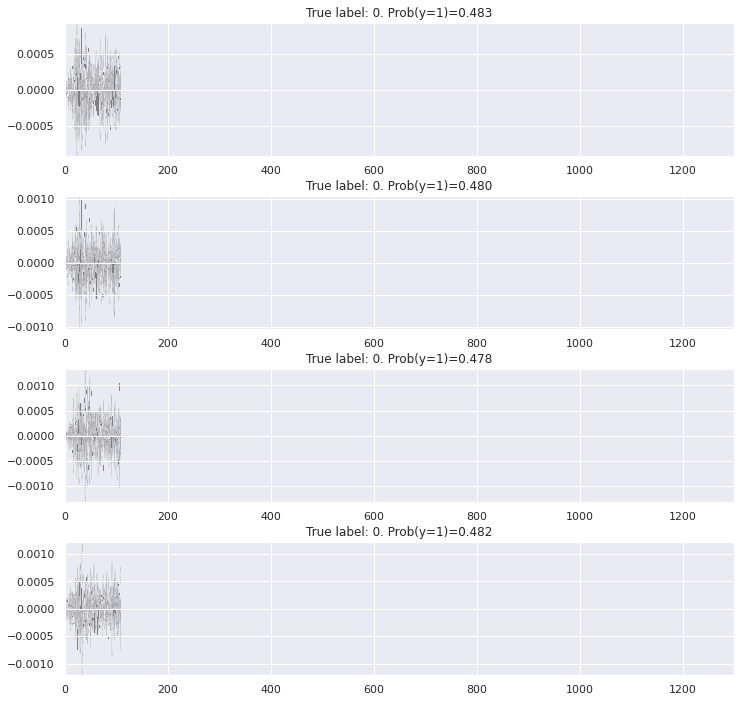

In [ ]:
delta_output_np = delta_output.detach().cpu().numpy()
delta_output_np -= delta_output_np.mean(1, keepdims=True)
output_np = output.detach().cpu().numpy()
plt.figure(figsize = (12,12))
for i in range(1,5):
    ax = plt.subplot(4,1,i)
    pwm_df = pd.DataFrame(data = delta_output_np[i,:,:].transpose(), columns=("A","C","G","T", "M"))
    crp_logo = logomaker.Logo(pwm_df, ax = ax) # CCGCGNGGNGGCAG or CTGCCNCCNCGCGG
    plt.title("True label: %i. Prob(y=1)=%.3f" % (y_cpu[i],output_np[i]))

plt.subplots_adjust(hspace = 0.3)

Create a LSTM RNN:

In [ ]:
class MyRNNLayer(nn.Module):
    
    def __init__(self, rnn_cell):
        super(MyRNNLayer, self).__init__()
        self.rnn_cell = rnn_cell

    @property
    def hidden_size(self):
        return self.rnn_cell.hidden_size

    @property
    def input_size(self):
        return self.rnn_cell.input_size
        
    def forward(self, x): 
        (seq_len, batch_size, input_size) = x.shape
        hidden = torch.zeros(batch_size, self.hidden_size, device = x.device) # could be an input to the function
        output = torch.zeros(seq_len, batch_size, self.hidden_size, device = x.device)
        for i in range(seq_len): # iterate over sequence
            hidden = self.rnn_cell(x[i,:,:], hidden)
            output[i,:,:] = hidden
        return output

In [ ]:
import timeit

def run_one_epoch_notused(train_flag, dataloader, model, optimizer, device="cuda"):

    torch.set_grad_enabled(train_flag)
    model.train() if train_flag else model.eval()

    losses = []
    accuracies = []

    for meth,unmeth in dataloader:
        
        # DataLoader's automatic batching makes batch x seq x cells tensors, 
        # For RNNs we want seq x batch x cells
        meth = meth.transpose(0,1).contiguous() 
        unmeth = unmeth.transpose(0,1).contiguous()

        (meth, unmeth) = ( meth.to(device), unmeth.to(device) ) # transfer data to GPU

        # forward
        logodds = model(meth, unmeth) # the output is seq x batch x cells

        lo = logodds[:-1,:,:] # shift by one since we're doing one-step (i.e. one CpG) ahead prediction
        prob_methylated = torch.sigmoid(lo)

        print(torch.log(prob_methylated).shape)
        print(meth[:-1,:,:].shape)

        first = (torch.log(prob_methylated) * meth[:-1,:,:])
        second = (torch.log(1 - prob_methylated) * unmeth[:-1,:,:])
        loss = -1 * (first + second).sum()

        losses.append(loss.detach().cpu().numpy())

        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        # calculate accuracy
        meth_sum = meth[1:,:,:] + unmeth[1:,:,:]
        meth_rate = meth[1:,:,:] / meth_sum
        correct = ((meth_rate > .5) == (prob_methylated > .5))[meth_sum > 0]
        accuracy = torch.mean( correct.float() )

        accuracies.append(accuracy.detach().cpu().numpy())  

    return( np.mean(losses), np.mean(accuracies) )

def run_one_epoch(train_flag, dataloader, model, optimizer, device="cuda"):
    torch.set_grad_enabled(train_flag)
    cnn_1d.train() if train_flag else cnn_1d.eval() 

    losses = []
    accuracies = []

    for (x,y) in dataloader: # collection of tuples with iterator

        (x, y) = ( x.to(device), y.to(device) ) # transfer data to GPU

        output = model(x, y)
        #output = cnn_1d(x) # forward pass
        #output = output.squeeze() # remove spurious channel dimension
        #loss = F.binary_cross_entropy_with_logits( output, y ) # numerically stable
        theloss = nn.MSELoss()
        loss = theloss(output, y)
        
        if train_flag: 
            loss.backward() # back propagation
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.detach().cpu().numpy())
        accuracy = torch.mean( ( (output > .5) == (y > .5) ).float() )
        accuracies.append(accuracy.detach().cpu().numpy())  
    
    return( np.mean(losses), np.mean(accuracies) )

def train_loop(model,
               optimizer,
               train_dataloader, 
               validation_dataloader,
               check_point_filename = '/content/drive/My Drive/scBSseq/rnn_checkpoint.pt',
               max_epochs = 10, 
               patience = 10,
               device = "cuda",
                batch_size=10, n_epochs=10, n_features=23):
    train_accs = []
    val_accs = []
    patience_counter = patience
    best_val_loss = np.inf

    for epoch in range(0,1):
        start_time = timeit.default_timer()
        train_loss, train_acc = run_one_epoch(True, train_dataloader, model, optimizer, device)
        val_loss, val_acc = run_one_epoch(False, validation_dataloader, model, optimizer, device)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        elapsed = float(timeit.default_timer() - start_time)
        print("Epoch %i took %.2fs. Train loss: %.4f acc: %.4f. Val loss: %.4f acc: %.4f. Patience left: %i" % 
            (epoch+1, elapsed, train_loss, train_acc, val_loss, val_acc, patience_counter ))
        
        if val_loss < best_val_loss: 
            torch.save(model.state_dict(), check_point_filename)
            best_val_loss = val_loss
            patience_counter = patience
        else: 
            patience_counter -= 1
            if patience_counter <= 0: 
                model.load_state_dict(torch.load(check_point_filename)) # recover the best model so far
                break
    
    return(train_accs, val_accs)

In [ ]:
class MethModel(nn.Module):
    def __init__(self, rnn_layer, input_size = 180, output_size = 1, batch_size = 64, n_epochs = 10, n_features = 23):
        super(MethModel, self).__init__()
        self.hidden_size = rnn_layer.hidden_size
        #self.embed = nn.Linear(input_size, rnn_layer.input_size) # the embed layer runs independently on each pair of meth/unmeth counts
        #self.embed = nn.Linear(input_size, 1300)
        self.embed = nn.Linear(1300, 1300)
        self.rnn_layer = rnn_layer
        #self.linear = nn.Linear(self.hidden_size, output_size)
        self.linear = nn.Linear(32, 1300)
        self.linear2 = nn.Linear(1300, 1)

        self.hidden_dim = self.hidden_size
        self.layer_dim = layer_dim
        self.input_dim = input_size
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.n_features = n_features

        self.rnn = rnn_layer
        self.fc = self.linear


    def forward(self, meth, nothing): # meth  = input data
        print(meth.shape)
        batch_size = meth.shape[1]
        num_cells = meth.shape[2]
 
        x = meth 
        x = self.embed(x) 
        x = F.relu(x)
        h = self.rnn_layer(x) 
      
        if isinstance(rnn_layer, nn.RNNBase): h = h[0] 
        output1 = self.linear(h)
        output = self.linear2(output1)

        return output

Train Dataset 1 through the LSTM RNN

In [ ]:
import torch.optim as optim

#citation for these values: towardsdatascience.com
input_dim = len(train_data.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

rnn_layer = nn.LSTM(input_size = 1300, hidden_size = hidden_size)
model = MethModel(rnn_layer)
device = "cuda"
model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_dataset = LiorDataset(train_data_f, genome, cnn_1d.seq_len, train_data, expression_db)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, num_workers = 0)
validation_dataset = LiorDataset(validation_data_f, genome, cnn_1d.seq_len, validation_data, expression_db)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1000)

test_dataset = LiorDataset(test_data_f, genome, cnn_1d.seq_len, test_data, expression_db)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, num_workers = 0)

train_accs, val_accs = train_loop(model,
                                optimizer,
                                train_dataloader, 
                                validation_dataloader,
                                check_point_filename = 'rnn_checkpoint.pt',
                                device = device,
                                max_epochs = 30,
                                batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)


test_loss, test_acc = run_one_epoch(False, test_dataloader, model, optimizer, device)
print(test_acc)

Get test accuracy

In [ ]:
test_dataset = LiorDataset(test_data_f, genome, cnn_1d.seq_len, test_data, expression_db )
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_loss, test_acc = run_one_epoch(False, test_dataloader, cnn_1d, optimizer, device)
test_acc